In [498]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [499]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

,price,price_log,sqft_above,sqft_above_log,sqft_lot,sqft_lot_log,sqft_living15,sqft_living15_log,sqft_lot15,age,...,zip_C,zip_D,zip_E,zip_F,zip_G,zip_H,zip_I,zipcode,lat,long
15937,268950.0,12.502281,880,6.779922,8100,8.999619,1000,6.907755,8100,72,...,0,0,1,0,0,0,0,98166,47.4697,-122.351
20963,399900.0,12.898970,900,6.802395,1005,6.912743,1440,7.272398,1188,4,...,0,0,0,0,1,0,0,98027,47.5446,-122.018
7614,339000.0,12.733755,720,6.579251,4128,8.325548,1510,7.319865,4538,73,...,0,0,0,0,0,0,0,98126,47.5296,-122.379
3257,380000.0,12.847927,840,6.733402,7372,8.905444,1930,7.565275,5150,76,...,0,0,0,0,0,0,0,98126,47.5285,-122.378
16723,365000.0,12.807653,1600,7.377759,4168,8.335192,1190,7.081709,4168,88,...,0,0,0,0,0,0,0,98126,47.5297,-122.381


In [500]:
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'condition', 'water_1.0',
       'base_1.0', 'reno_1.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E',
       'zip_F', 'zip_G', 'zip_H', 'zip_I', 'zipcode', 'lat', 'long'],
      dtype='object')

# MODEL 1: USING STEPWISE SELECTION
## WITH ALL FEATURES (p_value < 0.05) INCLUDED

In [501]:
#including all log-transformed features without neighborhood information
preprocessed_log_1 = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 
                        'age', 'bedrooms', 'bathrooms', 'floors', 'condition',
                        'water_1.0', 'base_1.0', 'reno_1.0']]

With the linear regression, you would interpret log transformed variables as a percentage change. Here’s a quick breakdown: (http://data-slinky.com/2016/09/06/log_trans.html)

* If your response variable, y, is log-transformed and assuming you have one predictor, a unit increase in the predictor x is associated with the x’s coefficient, call it b1, (b1*100) percentage increase in y.
* If your predictor is log-transformed(e.g., log(x)), then one unit increase of x means a (b1/100) percent increase in y.
* If both the response and the predictor is log-transformed then a one percent increase in x means a b1 percent increase in y.

In [502]:
preprocessed_log_1.shape

(21420, 12)

In [503]:
X = preprocessed_log_1.drop(['price_log'], axis=1)
y = preprocessed_log_1['price_log']

We checked for linearity in the first part of the project. Now we are checking out the next two assumptions — normality and homoscedasticity. This requires us to first create a regression model because they refer to a model’s residuals rather than its features. 

This part of the project includes:

1. Fitting an initial regression model, and then conducting statistical analyses of the results. We'll take a look at the p-values of the various features and perform some feature selection. We'll test for regression assumptions including normality, heteroscedasticity, and independence. 
2. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.

## Perform Stepwise Selection

In [504]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [505]:
#apply function
result = stepwise_selection(X, y, verbose = True)
print('Resulting Features 2:')
print(result)

Add  sqft_above_log                 with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  age                            with p-value 3.93411e-295
Add  sqft_living15_log              with p-value 3.29016e-297
Add  floors                         with p-value 1.43352e-207
Add  bathrooms                      with p-value 6.93609e-106
Add  water_1.0                      with p-value 1.82323e-102
Add  bedrooms                       with p-value 6.45593e-80
Add  sqft_lot_log                   with p-value 2.3291e-65
Add  condition                      with p-value 5.77263e-29
Add  reno_1.0                       with p-value 6.01818e-05
Resulting Features 2:
['sqft_above_log', 'base_1.0', 'age', 'sqft_living15_log', 'floors', 'bathrooms', 'water_1.0', 'bedrooms', 'sqft_lot_log', 'condition', 'reno_1.0']


Recall that a common significance cutoff of p-value is 0.05. Our model should eliminate these irrelevant features.

**Features that satified p-value requirement:** 'grade', 'zip_F', 'zip_A', 'zip_C', 'zip_B', 'age', 'bathrooms', 'sqft_living15_log', 'zip_G', 'water_1.0', 'zip_I', 'cond_3.0', 'sqft_lot_log', 'cond_2.0', 'zip_E', 'floors_1.5', 'base_1.0', 'reno_1.0', 'floors_2.0', 'floors_3.0', 'cond_5.0', 'floors_2.5', 'cond_4.0', 'sqft_lot15_log', 'zip_H', 'zip_D', 'bedrooms'

The null hypothesis for multiple regression states that there is no relationship between the chosen features and the target 'price'. All of the above p-values round to 0, which means we can reject the null hypothesis. All of the p-values indicate that all of the current features are substantially influential.

In [506]:
#check out how many features satisfy p < 0.05
len(result)

11

## Build Model in Statsmodels

In [507]:
#build initial model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_1 = sm.OLS(y,X_intercept).fit() 

#get summary
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2721.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:37:23   Log-Likelihood:                -7224.7
No. Observations:               21420   AIC:                         1.447e+04
Df Residuals:                   21408   BIC:                         1.457e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.9578      0.070     70.341      0.000       4.820       5.096
sqft_above_log        0.5729      0.012     47.340      0.000       0.549       0.597
base_1.0              0.2593      0.006     42.456      0.000       0.247       0.271
age                   0.0051      0.000     47.056      0.000       0.005       0.005
sqft_living15_log     0.4911      0.011     44.601      0.000       0.470       0.513
floors                0.0894      0.007     13.692      0.000       0.077       0.102
bathrooms             0.1240      0.005     23.067      0.000       0.113       0.135
water_1.0             0.6049      0.028     21.235      0.000       0.549       0.661
bedrooms             -0.0660      0.003    -19.838      0.000      -0.073      -0.059
sqft_lot_log         -0.0568      0.003    -17.576      0.000      -0.063      -0.050
condition             0.0458      0.004     11.664      0.000       0.038       0.054
reno_1.0              0.0537      0.013      4.013      0.000       0.027       0.080
==============================================================================
Omnibus:                        9.084   Durbin-Watson:                   1.019
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.878
Skew:                          -0.001   Prob(JB):                      0.00716
Kurtosis:                       3.105   Cond. No.                     1.66e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* We have a JB value = ~978, which is very high and not in favor of normality. 
* p-value of 0 which rejects the null hypothesis for normality. 
* Additionally, the kurtosis is ~4, where a kurtosis higher than 3 indicates heavier tails than a normal distribution. 
* The skewness value of 0.17 shows that underlying data is symmetrical. 

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

VIF quantifies how much the variance is inflated.

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

In [508]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed_log_1[result]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
list(zip(result, vif))

[('sqft_above_log', 1252.8111828226909),
 ('base_1.0', 2.5985592107043427),
 ('age', 6.030905318318472),
 ('sqft_living15_log', 983.5966209926839),
 ('floors', 20.098725805306433),
 ('bathrooms', 22.726262014078955),
 ('water_1.0', 1.0248078453557357),
 ('bedrooms', 23.885448733646918),
 ('sqft_lot_log', 157.4919955894484),
 ('condition', 33.52631573151659),
 ('reno_1.0', 1.153947658414174)]

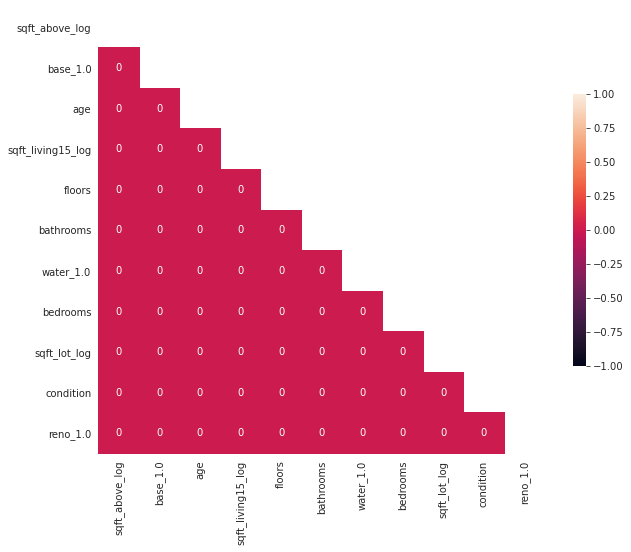

In [509]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    
plt.savefig('./Data & Figures/model_1_multicollinarity_check')

**Recheck for normality**

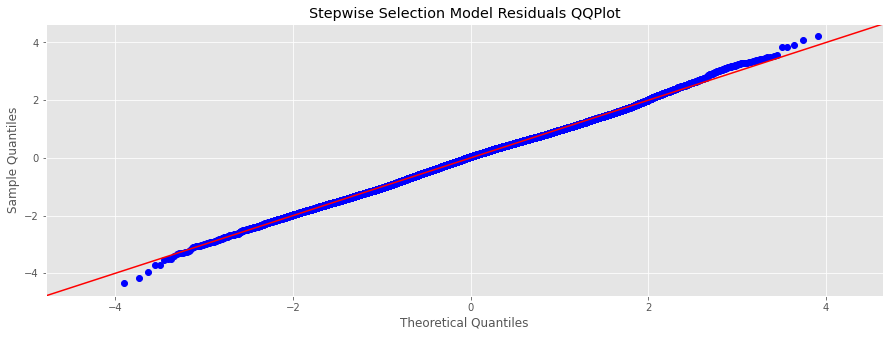

<Figure size 432x288 with 0 Axes>

In [510]:
#recheck for normality
fig = sm.graphics.qqplot(model_1.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Stepwise Selection Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_1_residuals_qqplot')

**Recheck for homoscedasticity**

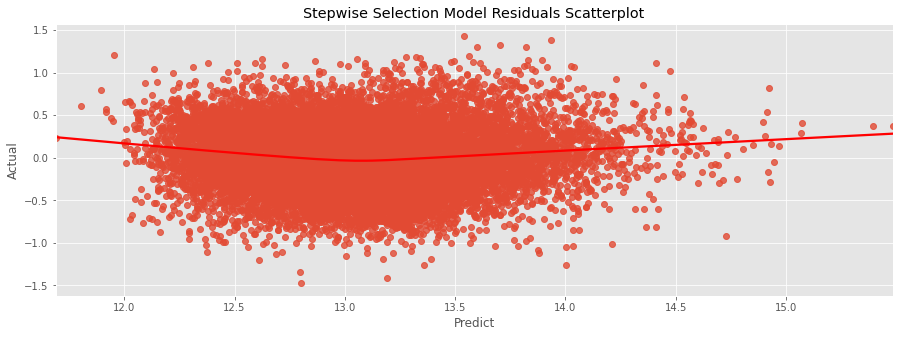

<Figure size 432x288 with 0 Axes>

In [511]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_1.predict(), 
            y = model_1.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Stepwise Selection Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_1_homoscedasticity_regplot')

**Recheck for overfitting: K-Fold Cross Validation**

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called K-Fold Cross Validation. The downside of the train test split is that every time we do a split we obtain a slighlty different result. That's where doing Cross-Validation has a big advantage because with it we're doing a multiple split test and getting the average value from it.

K-Fold Cross Validation expands on the idea of training and test splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

In [512]:
#cross-validation to check for overfitting (learn.co)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 50, scoring = mse)
cv_result

array([0.14145103, 0.09081511, 0.09988563, 0.13762767, 0.12069798,
       0.13903719, 0.09808501, 0.11997889, 0.12126538, 0.0681884 ,
       0.09715452, 0.08711063, 0.10930082, 0.09233113, 0.11736533,
       0.12022921, 0.10447108, 0.1012302 , 0.09559049, 0.15689474,
       0.12507282, 0.15172942, 0.11816115, 0.1137173 , 0.06766299,
       0.13948459, 0.10450987, 0.10668417, 0.1302793 , 0.0979881 ,
       0.10171325, 0.12502008, 0.10892397, 0.12106486, 0.11589647,
       0.12844489, 0.12956046, 0.11495256, 0.13520884, 0.09867288,
       0.12558312, 0.11246098, 0.11130062, 0.14576565, 0.11186885,
       0.13100741, 0.1266576 , 0.10819987, 0.11771851, 0.12920341])

In [513]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

0.11546448904521033

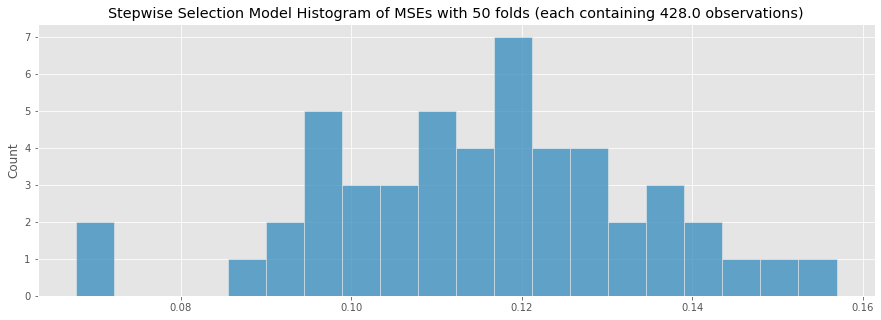

In [514]:
#visualize the cv_result

folds = 50
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 20);
plt.title('Stepwise Selection Model Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log) / folds, 0)));
plt.savefig('./Data & Figures/model_1_cv_result_histplot')

The above histogram suggests that even with 50 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted.

## Validate Model 1

In [515]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [516]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [517]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [518]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.11549854794985379
0.11279913659225038


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

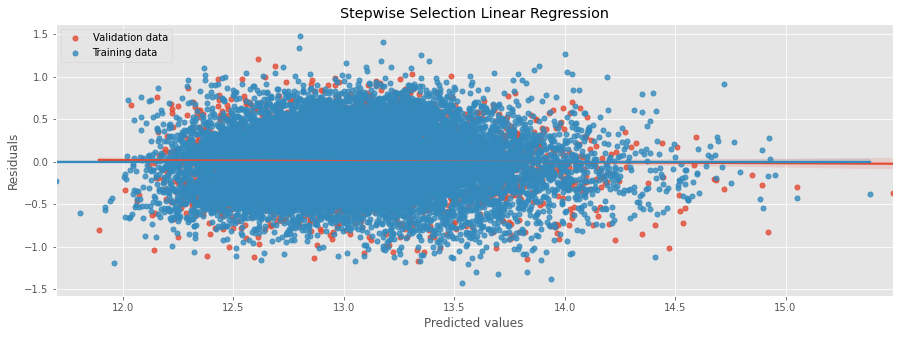

<Figure size 432x288 with 0 Axes>

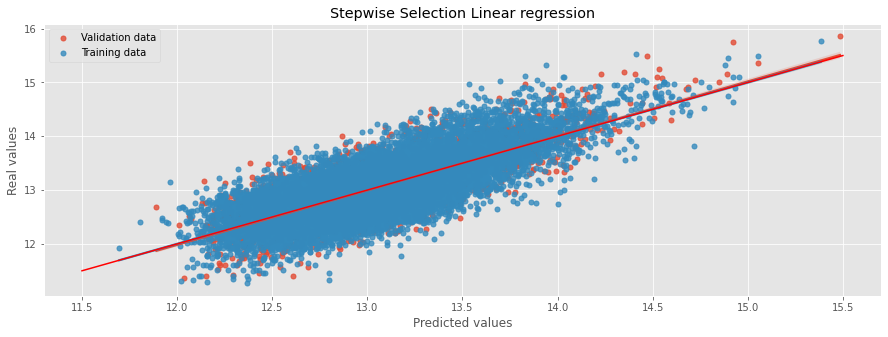

<Figure size 432x288 with 0 Axes>

In [519]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")


plt.title("Stepwise Selection Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_1_residuals_scatterplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")

plt.title("Stepwise Selection Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()
plt.savefig('./Data & Figures/model_1_predictions_scatterplot')

In [520]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 60%'

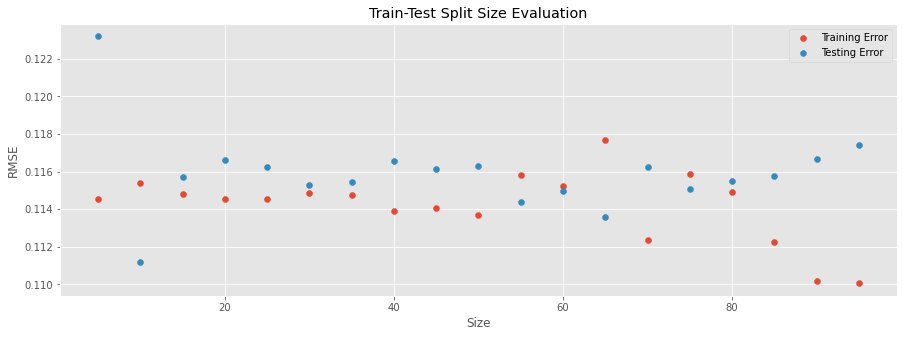

In [521]:
#evaluating the effect of train-test split size (learn.co)
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.figure(figsize = (15, 5))    
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.title('Train-Test Split Size Evaluation')
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.legend()

### Bias-Variance Tradeoff

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [522]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [523]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [524]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [525]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: -7.737457845699708 
Train variance: 0.05121454784319468


In [526]:
# Bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: -7.734744368908706 
Test variance: 0.054130709436730484


# MODEL 2: USING FEATURE RANKING 
# WITH RECURSIVE FEATURE ELIMINATION
# USING LOCATION FEATURES

Stepwise Selection selects features based on p-value. RFE ranks the variable on the basis on linear regression fit.
By combining them, we select for the 10 most important features.

RFE is popular because it is easy to configure and use and because it is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable.

RFE assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [529]:
preprocessed_log_2 = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                          'age', 'bedrooms', 'bathrooms', 'floors', 'condition',
                          'water_1.0', 'base_1.0', 'reno_1.0',
                          'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'zipcode', 'lat', 'long']]

In [531]:
X = preprocessed_log_2.drop(['price_log'], axis=1)
y = preprocessed_log_2['price_log']

In [532]:
#feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#set number of features to be 11 to be consistent with previous Model 1 of Stepwise Selection
selector = RFE(linreg, n_features_to_select = 11) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
selector.support_

array([ True, False,  True, False, False, False, False, False,  True,
        True,  True, False, False, False,  True,  True,  True, False,
        True, False, False,  True,  True])

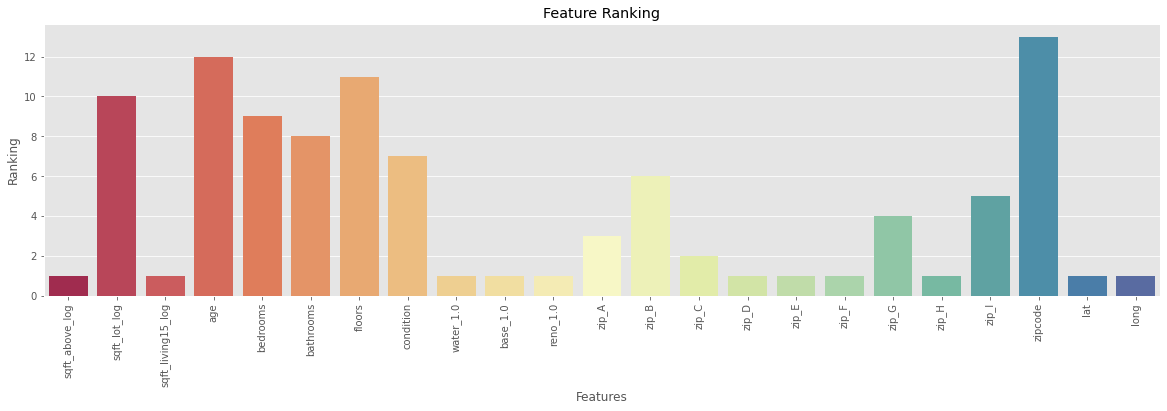

<Figure size 432x288 with 0 Axes>

In [533]:
#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X.columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/recursive_features_elimination')

**Stepwise Selection:** 'grade', 'zip_F', 'zip_A', 'zip_C', 'zip_B', 'age', 'bathrooms', 'sqft_living15_log', 'zip_G', 'water_1.0', 'zip_I', 'cond_3.0', 'sqft_lot_log', 'cond_2.0', 'zip_E', 'floors_1.5', 'base_1.0', 'reno_1.0', 'floors_2.0', 'floors_3.0', 'cond_5.0', 'floors_2.5', 'cond_4.0', 'sqft_lot15_log', 'zip_H', 'zip_D', 'bedrooms'

**RFE:** 'age', 'bedrooms', 'floor_3.0', 'floor_2.0', 'sqft_lot15_log', 'sqft_lot_log', 'floors_3.5', 'base_1.0', 'zip_I', 'zip_G'

In [534]:
#fit the linear regression model again using the selected columns
selected_features = X.columns[selector.support_ ]
linreg.fit(X[selected_features], y)

LinearRegression()

In [535]:
#build model 2 in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_2 = sm.OLS(y,X_intercept).fit() 

#get summary
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     5741.
Date:                Fri, 22 Jan 2021   Prob (F-statistic):               0.00
Time:                        02:43:20   Log-Likelihood:                -1879.9
No. Observations:               21420   AIC:                             3784.
Df Residuals:                   21408   BIC:                             3879.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -83.7537      2.048    -40.892      0.000     -87.768     -79.739
sqft_above_log        0.5970      0.007     91.098      0.000       0.584       0.610
sqft_living15_log     0.4060      0.009     47.758      0.000       0.389       0.423
water_1.0             0.7329      0.022     32.978      0.000       0.689       0.776
base_1.0              0.2048      0.004     49.390      0.000       0.197       0.213
reno_1.0              0.1471      0.010     14.753      0.000       0.128       0.167
zip_D                -0.4963      0.009    -57.846      0.000      -0.513      -0.480
zip_E                -0.4824      0.009    -52.592      0.000      -0.500      -0.464
zip_F                -0.6470      0.011    -59.026      0.000      -0.668      -0.626
zip_H                -0.3896      0.010    -37.969      0.000      -0.410      -0.370
lat                   0.1131      0.026      4.433      0.000       0.063       0.163
long                 -0.6873      0.016    -43.260      0.000      -0.718      -0.656
==============================================================================
Omnibus:                      432.199   Durbin-Watson:                   1.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              906.895
Skew:                           0.071   Prob(JB):                    1.18e-197
Kurtosis:                       3.998   Cond. No.                     1.49e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With location features included, our r2 increases to 0.747, meaning our Model 2 performs better than our Model 1 (without location features)

In [536]:
#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

array([12.28718869, 12.71060359, 12.8430895 , ..., 12.70814069,
       12.83558163, 12.69977451])

r_square is used as "goodness of fit" which measure of the fitted line. It can take values between 0 and 1.
* r2 ~ 0 = poor fit
* r2 ~ 1 = good fit

Our r_squared and adjusted_r_squared are very very similar in both cases: 63% of the dataset's variation from the mean can be explained by our model.

In [537]:
#get intercept
linreg.intercept_

-83.75368105630378

In [538]:
#get coefficients and sort them
coefficients = dict(zip(X,list(linreg.coef_)))
dict(sorted(coefficients.items(), key=lambda item: item[1]))

{'reno_1.0': -0.6873487907884096,
 'condition': -0.6470005161531346,
 'bathrooms': -0.49633572576153656,
 'floors': -0.4823867888666266,
 'water_1.0': -0.38961313882120024,
 'base_1.0': 0.11309849560222768,
 'bedrooms': 0.14708095938537585,
 'age': 0.20477264088604633,
 'sqft_lot_log': 0.4059519708358817,
 'sqft_above_log': 0.5970132875223036,
 'sqft_living15_log': 0.7329138473819542}

**Features that add values:**
* 'grade'
* 'sqft_living15'
* 'base_1.0'
* 'age'
* 'bathrooms'
* 'floors_1.5' & 'floors_3.5'
* 'sqft_lot': 
* 'water_1.0':

**Features that lower values:**
* 'floors_2.0', 'floors_2.5' & 'floors_3.0'
* 'cond_2.0', 'cond_3.0' & 'cond_4.0'
* 'sqft_lot15'
* 'reno_1.0'
* 'bedrooms'

## Test Model 2

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

In [539]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
X = preprocessed_log_2[selected_features]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] 
list(zip(selected_features, vif))

[('sqft_above_log', 717.3450114283842),
 ('sqft_living15_log', 1224.777643222891),
 ('water_1.0', 1.0319304065705386),
 ('base_1.0', 2.003317455322572),
 ('reno_1.0', 1.0505482018293568),
 ('zip_D', 1.59478863730827),
 ('zip_E', 1.6559247652538474),
 ('zip_F', 2.7671947697135293),
 ('zip_H', 1.779200593760795),
 ('lat', 390119.95214355254),
 ('long', 386458.272461055)]

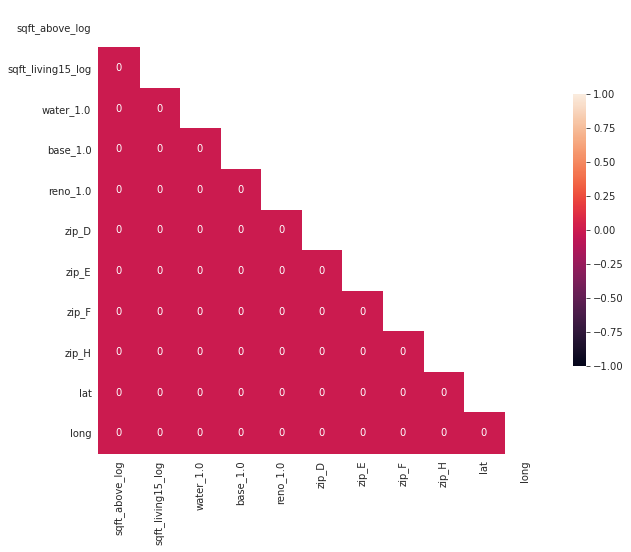

In [540]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    
plt.savefig('./Data & Figures/model_2_multicollinarity_check')

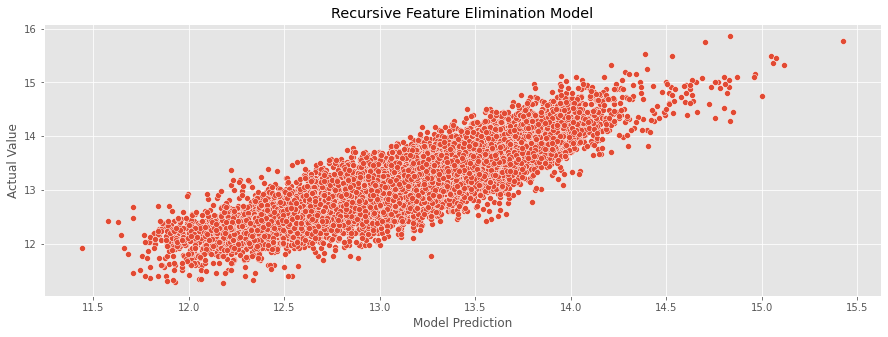

In [541]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.scatterplot(yhat, y)
plt.title('Recursive Feature Elimination Model')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_2_scatterplot')

**Recheck for normality**

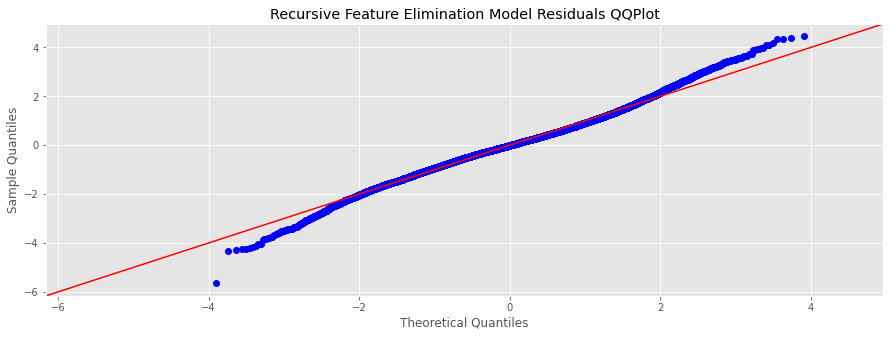

<Figure size 432x288 with 0 Axes>

In [542]:
#recheck for normality
fig = sm.graphics.qqplot(model_2.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Recursive Feature Elimination Model Residuals QQPlot')
plt.show()
plt.savefig('./Data & Figures/model_2_residuals_qqplot')

Initial model satisfied normality assumption.

**Recheck for homoscedasticity**

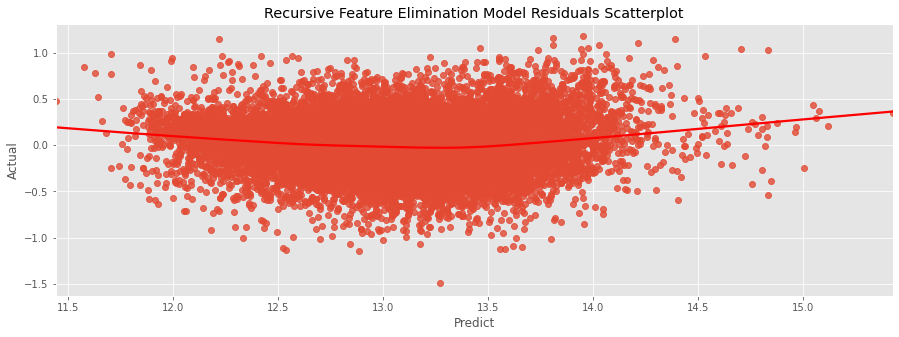

<Figure size 432x288 with 0 Axes>

In [543]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_2.predict(), 
            y = model_2.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Recursive Feature Elimination Model Residuals Scatterplot')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()
plt.savefig('./Data & Figures/model_2_homoscedasticity_regplot')

Initial model satisfied homoscedasticity assumption.

**Recheck for overfitting: K-Fold Cross Validation**

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called K-Fold Cross Validation. The downside of the train test split is that every time we do a split we obtain a slighlty different result. That's where doing Cross-Validation has a big advantage because with it we're doing a multiple split test and getting the average value from it.

K-Fold Cross Validation expands on the idea of training and test splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

In [544]:
#cross-validation to check for overfitting (learn.co)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()

#get the mean squared error
mse = make_scorer(mean_squared_error)

cv_result = cross_val_score(linreg, X, y, cv = 50, scoring = mse)
cv_result

array([0.07801027, 0.053507  , 0.06012226, 0.08340741, 0.06070027,
       0.04841686, 0.05388408, 0.06419971, 0.09209614, 0.04658949,
       0.06693881, 0.0529119 , 0.06439615, 0.06519247, 0.07312409,
       0.06227354, 0.07875881, 0.08491035, 0.06744003, 0.07142285,
       0.06350141, 0.09362908, 0.08409559, 0.06649875, 0.07648739,
       0.08344088, 0.05322521, 0.06588603, 0.09075308, 0.08807664,
       0.06840083, 0.07445332, 0.06306083, 0.07450411, 0.06317556,
       0.06607477, 0.06907206, 0.06748394, 0.0715443 , 0.0595953 ,
       0.07570252, 0.05903802, 0.07056421, 0.07178125, 0.08867218,
       0.07519879, 0.08476064, 0.07103185, 0.06700717, 0.07734787])

In [545]:
#the accuracy of the model is the average of the accuracy of each fold
cv_result.mean()

0.07024732195324462

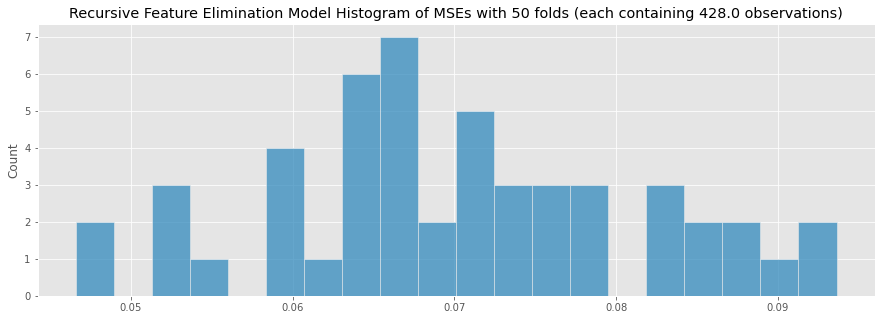

In [546]:
#visualize the cv_result
folds = 50
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 20);
plt.title('Recursive Feature Elimination Model Histogram of MSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_2) / folds, 0)));
plt.savefig('./Data & Figures/model_2_cv_result_histplot')

The above histogram suggests that even with 50 folds, the MSE fall in a relatively narrow range. This suggests that the model is not overfitted.

## Validate Model 2

In order to get a good sense of how well our model will be doing on new instances, we'll have to perform a so-called "train-test-split". What we'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [547]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [548]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [549]:
#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [550]:
#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

0.07035209209429479
0.06754861102808832


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

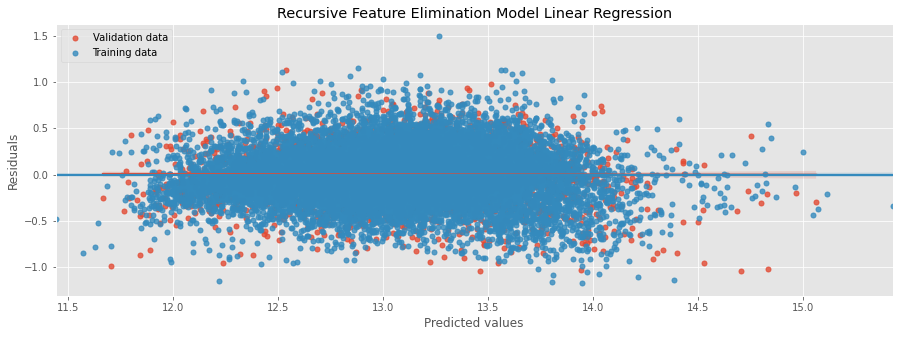

<Figure size 432x288 with 0 Axes>

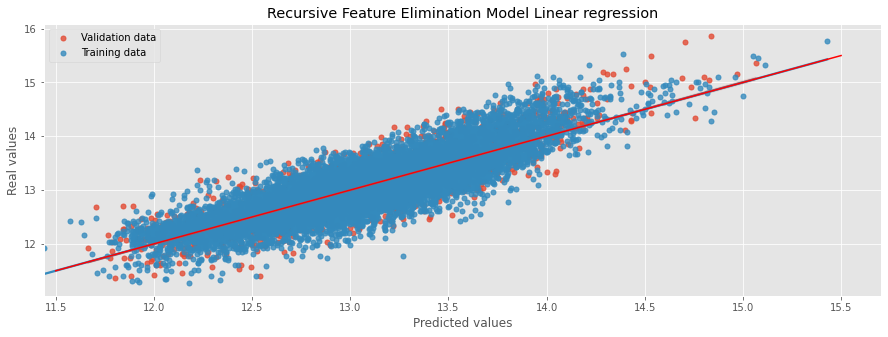

<Figure size 432x288 with 0 Axes>

In [551]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")

plt.title("Recursive Feature Elimination Model Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_2_residuals_scatterplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws={"s": 25}, fit_reg = True, label = "Training data")

plt.title("Recursive Feature Elimination Model Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11.5, 15.5], [11.5, 15.5], c = "red")
plt.show()
plt.savefig('./Data & Figures/model_2_predictions_scatterplot')

In [552]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 76%'

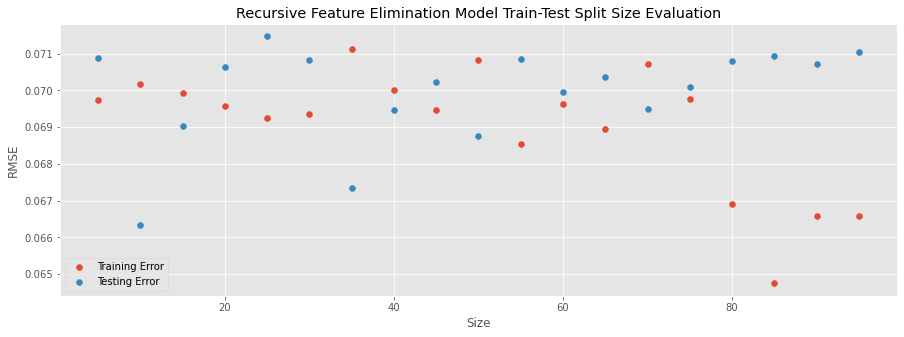

In [553]:
#evaluating the effect of train-test split size (learn.co)
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))

for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
    
plt.figure(figsize = (15, 5))    
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.title('Recursive Feature Elimination Model Train-Test Split Size Evaluation')
plt.xlabel('Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('./Data & Figures/model_2_traintestsplit_scatterplot')

### Bias-Variance Tradeoff

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [554]:
# Transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [555]:
# Training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [556]:
# Bias and variance for training set 
b = bias(y_train, lm_train_predictions) 
v = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b, v))

Train bias: -99.2470027111491 
Train variance: 0.11988401346752653


In [557]:
# Bias and variance for test set 
b = bias(y_test, lm_test_predictions) 
v = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b, v))

Test bias: -99.23404188249549 
Test variance: 0.12164642847710638


## MODEL REFINEMENT I: 
## Apply Polynomial Regression

Now it's time to determine the optimal degree of polynomial features for a model that is fit to this data. For each of second, third and fourth degrees: 

- Instantiate `PolynomialFeatures()` with the number of degrees 
- Fit and transform the `X_train` features 
- Instantiate and fit a linear regression model on the training data 
- Transform the test data into polynomial features 
- Use the model you built above to make predictions using the transformed test data 
- Evaluate model performance on the test data using `r2_score()` 
- In order to plot how well the model performs on the full dataset, transform `X` using `poly` 
- Use the same model (`reg_poly`) to make predictions using `X_poly` 

ValueError: x and y must be the same size

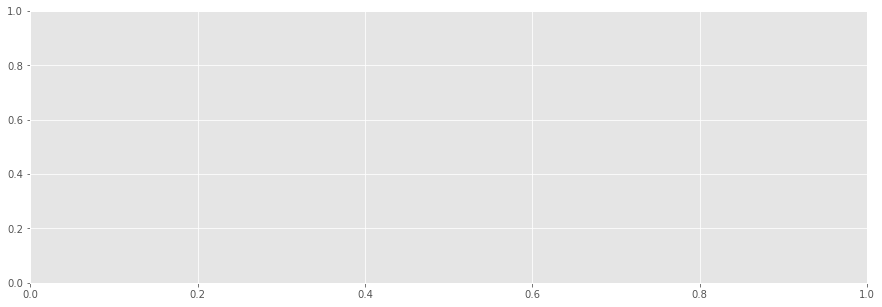

In [497]:
# We'll fit 3 different polynomial regression models from degree 2 to degree 4
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

colors = ['yellow', 'lightgreen', 'blue']
plt.figure(figsize=(15, 5))
plt.scatter(preprocessed_2[X.columns], preprocessed_2['price_log'], color='green', s=50, marker='.', label='plot points')

# We'll fit 3 different polynomial regression models from degree 2 to degree 4
for index, degree in enumerate([2, 3, 4]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.fit_transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data 
    y_poly = reg_poly.predict(X_poly)
    
    # Create plot of predicted values
    plt.plot(X, y_poly, color = colors[index], linewidth=2, label='degree %d' % degree)
    plt.legend(loc='lower left')

We see that the r2 is highest ( r2=0.767) and the root mean square error is lowest (rmse=0.255) for third order polynomial .So lets add a polynomil of degree 3 to out linear regression model. It will include interactions between diffrent features and make our model more complex.

Not adding polynomials is prone to overfitting.

The predicted values of home prices ( by this model)=Actual value of home prices +- 1.3%

The root mean square error for the training and the test sets are low and almost the same (rmse_test=0.279,rmse_training=0.266).So there is no over fitting or underfitting.Adding a polynomial of degree 3 and regularizing the model with Lasso regularization controlled for underfitting and over fitting.

## MODEL REFINEMENT II:
## INTERACTIONS

### See how interactions improve our baseline

Create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the  𝑅2 . We'll look at the 3 interactions which have the biggest effect on our  𝑅2 , so print out the top 3 combinations.

**Comment:** While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables. With that, it makes sense to briefly update the features once again and recheck for multicollinearity.

In [ ]:
regression = LinearRegression()

In [ ]:
crossvalidation = kFold(n_splits = 10, shuffle = True, random_state =1)

In [ ]:
baseline = np.mean(cross_val_score(regression, X, y, scoring = 'r2', cv = crossvalidation))
baseline

In [ ]:
from itertools import combinations (learn.co)

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against SalePrice. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

In [ ]:
#fig, ax = plt.subplots(figsize=(13, 10))

col = 'zip_C'

is_in = preprocessed.loc[preprocessed['zip_C'] == 1, [col, 'price']]

linreg = LinearRegression()
linreg.fit(np.log(is_in[[col]]), np.log(is_in['price']))

preds = linreg.predict(np.log(is_in[[col]]))

plt.scatter(np.log(is_in[[col]]), np.log(is_in['price']), alpha=.3, label=None)

x = np.linspace(6, 12)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'In zip_C:   {linreg.coef_[0]:.2f}')

not_in = preprocessed.loc[preprocessed['zip_C'] == 0, [col, 'price']]

linreg = LinearRegression()
linreg.fit(np.log(not_in[[col]]), np.log(not_in['price']))

preds = linreg.predict(np.log(not_in[[col]]))

plt.scatter(np.log(not_in[[col]]), np.log(not_in['price']), alpha=.1, label=None)

x = np.linspace(6, 12)
ax.plot(x, linreg.predict(x.reshape(-1, 1)), label=f'Outside of zip_C:   {linreg.coef_[0]:.2f}')

ax.legend()

In [ ]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['Neighborhood_Edwards*LotArea'] = final['Neighborhood_Edwards'] * final['LotArea']

final_model = np.mean(cross_val_score(regression, final, y, scoring='r2', cv=crossvalidation))

final_model

In [ ]:
#r2has increased considerably! Let's have a look in statsmodels to see if this interactions are significant.
import statsmodels.api as sm

df_inter_sm = sm.add_constant(final)
model = sm.OLS(y, final)
results = model.fit()

results.summary()